# HR Analytics: Job Change of Data Scientists
#### Análise de Dados de RH

# 0.0. IMPORTS

In [1]:
# manipulação dos dados
import pandas as pd
import numpy as np
import inflection

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno

# Estatística
import scipy
from scipy.stats import normaltest
from scipy.stats import chi2_contingency

## 0.1. Helper Functions

## 0.2. Loading data

In [2]:
df_raw = pd.read_csv('dataset/aug_train.csv', low_memory=False )

# 1.0. DESCRIÇÃO DOS DADOS

In [3]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [4]:
df_raw.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [5]:
cols_old = ['enrollee_id', 'city', 'city_development_index', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 
            'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'training_hours', 'target']

snakecase = lambda x: inflection.underscore ( x )

cols_new = list (map( snakecase, cols_old ) )

#rename
df1.columns = cols_new

## 1.2 Data Dimensions
###### Quantidade de linhas e colunas no dataset

In [6]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of Rows: 19158
Number of cols: 14


## 1.3 Data Types
###### Distribuição dos tipos de variáveis do dataset

In [7]:
df1.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

# 2.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [9]:
df2 = df1.copy()

## 2.1. Descrevendo os dados

In [10]:
# filtrando dados não numéricos
df2.describe( include=object )

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


In [11]:
# filtrando dados numéricos relevantes
df2.describe().drop(columns = ["enrollee_id", "target"])

,city_development_index,training_hours
count,19158.000000,19158.000000
mean,0.828848,65.366896
std,0.123362,60.058462
min,0.448000,1.000000
25%,0.740000,23.000000
50%,0.903000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


city_development_index (CDI) é um índice de desenvolvimento quanto maior melhor, ou seja, mais desenvolvida é a cidade.

- Em city_development_index (CDI) os valores médios são 0.828, mediana de 0.903 e desvio padrão de 0.123. Isso significa que a maioria dos candidatos são de cidades bem desenvolvidas

    - Podemos verificar que há valores que variam entre a min (0.448) e a max (0.949), mas com um desvio padrão baixo (0.123), temos uma indicação de pouca dispersao.
    - O desvio padrão(std) de 0.123 indica que provavelmente há pouca dispersão dessa variável. Quanto menor o std, menor a dispersão.

- Em training_hours, os valores médios estão em 65.366, mediana 47 e max de 336. Isso significa que há mais candidatos com poucas horas de treinamento, mas alguns candidatos gastam muito tempo para fazer o treinamento.


## 2.2. Verificando a distribuição dos dados categóricos


In [12]:
cat_columns = list( df2.columns.values )[3:12]
cat_columns

['gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

### 2.2.1. Plots

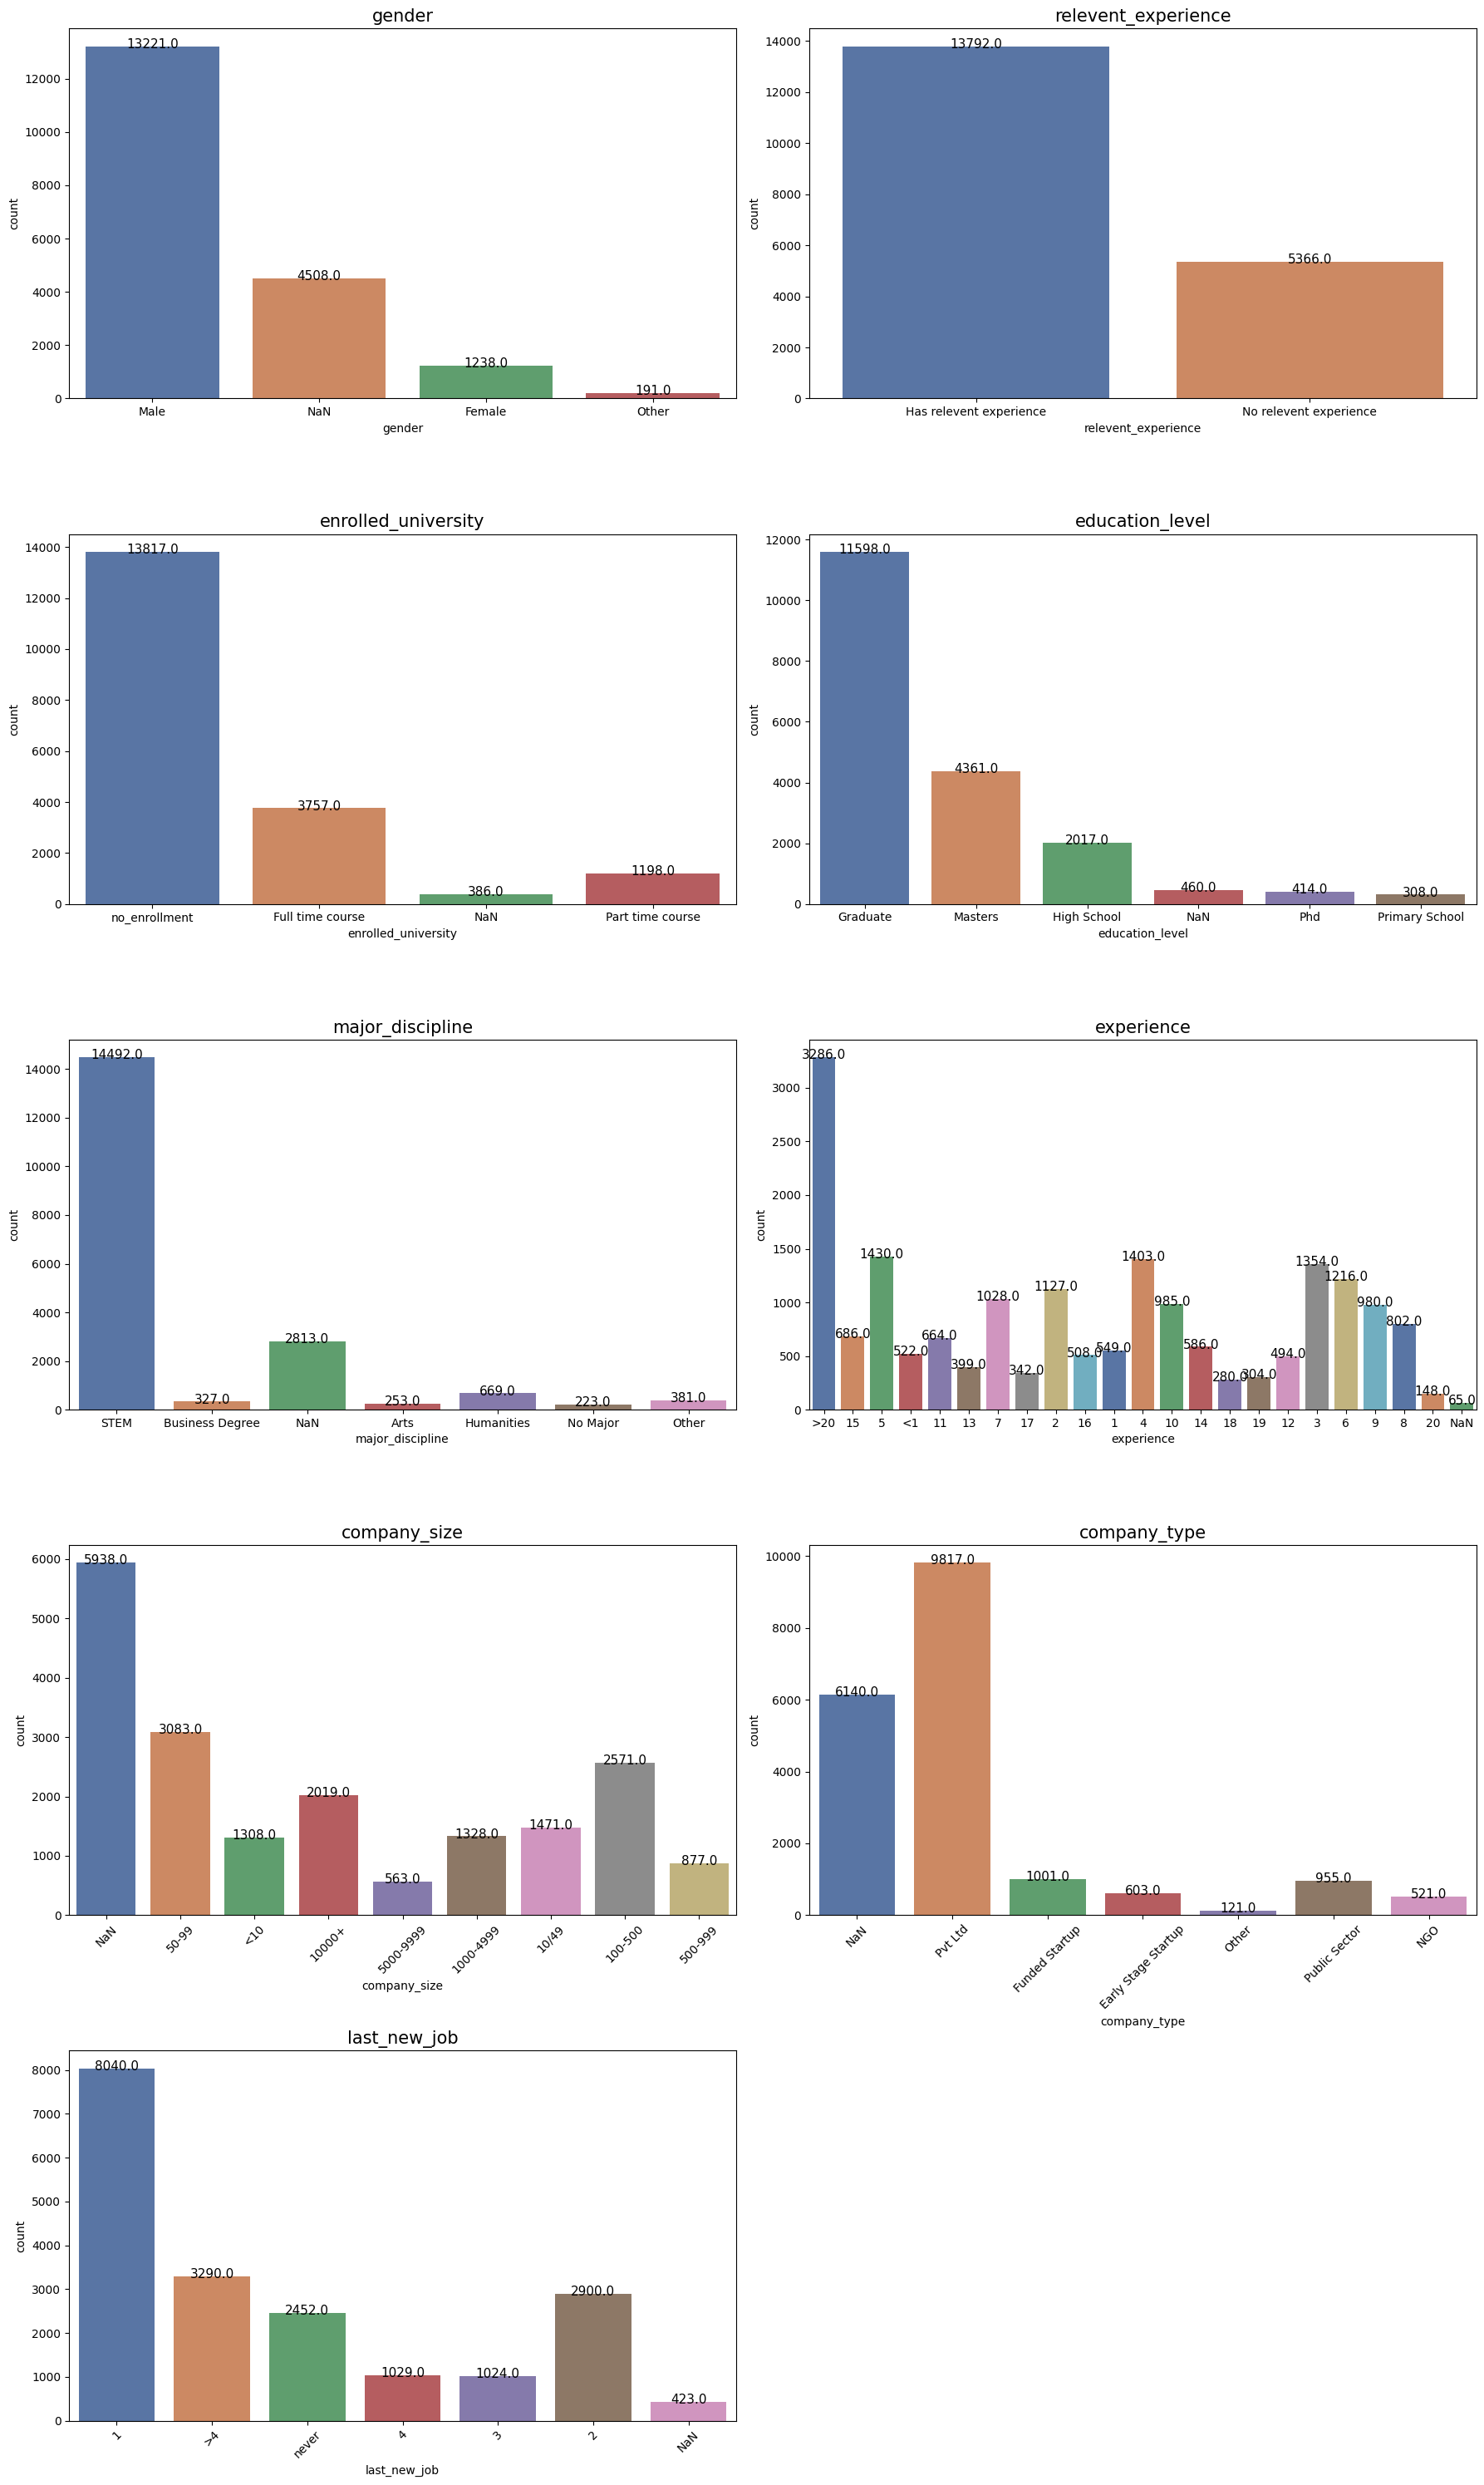

In [13]:
# Tamanho total da figura
plt.figure(figsize=(18, 30))

# Lista de colunas categóricas
column_list = cat_columns

# Contador de subplots
A = 0

# Loop pelos gráficos
for i in column_list:
    A += 1
    plt.subplot(5, 2, A)  # até 10 gráficos (5 linhas x 2 colunas)
    
    # Número de categorias distintas (incluindo NaNs)
    n_classes = df2[i].fillna('NaN').nunique()
    
    # Paleta dinâmica
    palette = sns.color_palette("deep", n_classes)
    
    # Gráfico
    ax = sns.countplot(data=df2.fillna('NaN'), x=i, hue=i, palette=palette, legend=False)
    
    # Título do gráfico
    plt.title(i, fontsize=15)
    
    # Anotação nas barras
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 8),
                    textcoords='offset points')
    
    # Rotação se necessário
    if A >= 7:
        plt.xticks(rotation=45)

# Ajuste de layout
plt.tight_layout(h_pad=2)

## 2.3. Verificando a distribuição dos dados numéricos

In [14]:
# filtrando dados numéricos relevantes
df2.describe().drop(columns = ["enrollee_id", "target"])

,city_development_index,training_hours
count,19158.000000,19158.000000
mean,0.828848,65.366896
std,0.123362,60.058462
min,0.448000,1.000000
25%,0.740000,23.000000
50%,0.903000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


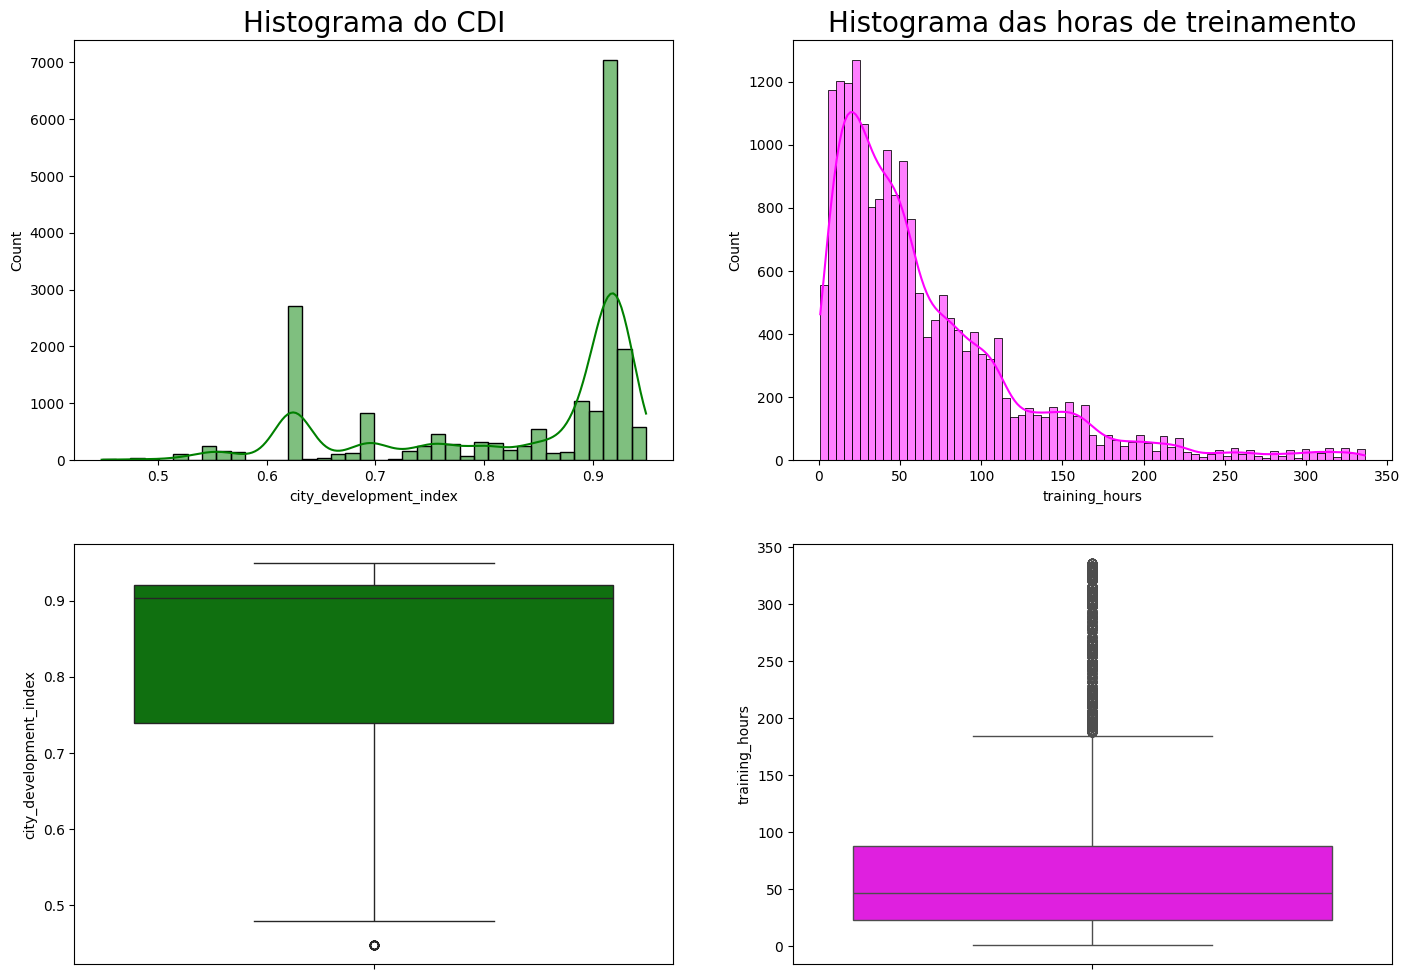

In [15]:
# Figura
plt.figure( figsize = (17, 12) )

# subplots com histogramas
plt.subplot(221)
sns.color_palette("hls", 8)
sns.histplot(df2['city_development_index'], kde = True, color="green")
plt.title('Histograma do CDI', fontsize=20)

plt.subplot(222)
sns.histplot(df2['training_hours'], kde = True, color="magenta")
plt.title('Histograma das horas de treinamento', fontsize=20)

# subplots com boxplots
plt.subplot(223)
sns.boxplot(df2['city_development_index'], color="green")

plt.subplot(224)
sns.boxplot(df2['training_hours'], color="magenta")

plt.show()

### 2.3.1. Teste de normalidade da distribuição

In [18]:
# lista com as variáveis numéricas
numerical_features = ['city_development_index', 'training_hours']

# Loop
for i in numerical_features:
    
    # calcula a normalidade
    stats, pval = normaltest(df2[i])

    # Checar valor-p
    if pval > 0.05:
        print(i, ': Distribuição normal')
    else:
        print(i, ': Distribuição NÃO normal')

city_development_index : Distribuição NÃO normal
training_hours : Distribuição NÃO normal


- As variáveis city_development_index e training_hours não seguem a distribuição normal. Para a análise numérica, usaremos o método não paramétrico.

- Dados de training_hours estão localizados principalmente no lado esquerdo do histograma. É um comportamento esperado porque as pessoas geralmente ficam animadas ao fazer o treinamento no início, mas nem todos que começam conseguem terminar uma maratona.